Marta Xiulan Aribó Herrera and German Anashkin

Data Driven Social Analytics - Assignment II

MIIS 2025

---



# Installs and Libraries

In [ ]:
!pip install snap-stanford pandas numpy matplotlib seaborn tqdm networkx

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ------- -------------------------------- 1.8/9.2 MB 11.2 MB/s eta 0:00:01
   --------- ------------------------------ 2.1/9.2 MB 13.0 MB/s eta 0:00:01
   ------------- -------------------------- 3.1/9.2 MB 7.4 MB/s eta 0:00:01
   ------------- -------------------------- 3.1/9.2 MB 7.4 MB/s eta 0:00:01
   ------------------ --------------------- 4.2/9.2 MB 4.6 MB/s eta 0:00:02
   --------------------------- ------------ 6.3/9.2 MB 5.4 MB/s eta 0:00:01
   ------------------------------------ --- 8.4/9.2 MB 6.2 MB/s eta 0:00:01
   ------------------------------------ --- 8.4/9.2 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 9.2/9.2 MB 5.1 MB/s eta 0:00:00


In [373]:
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np
import os
import pandas as pd
import powerlaw as pl
import seaborn as sns
import snap

from tqdm import tqdm

In [23]:
sns.set_theme()

# Download Data (Do not run)

In [ ]:
!wget http://www.sociopatterns.org/files/datasets/004/sg_infectious_contact_list.tgz

In [ ]:
!mkdir -p ../sociopatterns
!tar -xzf sg_infectious_contact_list.tgz -C ../sociopatterns
!ls ../sociopatterns

In [80]:

dataset = pd.DataFrame()
read_path = "../sociopatterns/"
save_path = "../data/"
for file in os.listdir(read_path):
  file = read_path + file
  df = pd.read_csv(file, delimiter='\t')
  df.columns = ['contact_time', 'user_1', 'user_2']
  dataset = pd.concat([dataset, df])

dataset.to_csv(save_path+"infectious_data.csv", index=False)

# Load Dataset

In [2]:
path = "../data/infectious_data.csv"
df = pd.read_csv(path)

# Converting UNIX time to datetime format
df['contact_time'] = df['contact_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))

## Graph Generation

In [3]:
# Graph creation

G = snap.TUNGraph.New()

for idx, row in tqdm(df.iterrows(), total=len(df)):
    if not G.IsNode(row['user_1']):
        G.AddNode(row['user_1'])

    if not G.IsNode(row['user_2']):
        G.AddNode(row['user_2'])

    G.AddEdge(row['user_1'], row['user_2'])

G.PrintInfo()

100%|██████████| 415843/415843 [00:43<00:00, 9635.73it/s] 

Graph:
  Nodes:                    10972
  Edges:                    44516
  Zero Deg Nodes:           0
  Zero InDeg Nodes:         0
  Zero OutDeg Nodes:        0
  NonZero In-Out Deg Nodes: 10972


In [4]:
# Save the graph
save_graph = snap.TFOut("../data/infectious.graph")
G.Save(save_graph)

In [5]:
# Load the graph
load_graph = snap.TFIn("../data/infectious.graph")
G = snap.TUNGraph.Load(load_graph)

# 1. Dataset Analysis

## a. General Characteristics of the Dataset

[DATASET LINK:  Infectious SocioPatterns dynamic contact networks ](href="http://www.sociopatterns.org/datasets/infectious-sociopatterns-dynamic-contact-networks/")

This dataset records face-to-face interactions between individuals overt time. It is structure into three columns: *user_1*, *user_2* and *contact_time*. Each row represents a recorded contact event between two individuals at a specific time. These names have been labeled by us for better understanding.

* *user_1* and *user_2* : Unique and anonymous identifiers assigned to individuals involved in a contact event.
* *contact_time* :  A timestamp representing the time interval [t-20s, t] during which the two individuals were in contact. The time is expressed in UNIX ctime format.

The dataset have shape of 415843 x 3

In [6]:
df.head()

,contact_time,user_1,user_2
0,2009-06-04 12:19:19,90505314,78184522
1,2009-06-04 12:19:19,90505314,78446676
2,2009-06-04 12:19:19,90505314,78577729
3,2009-06-04 12:19:19,78184522,75104339
4,2009-06-04 12:19:19,78446676,74973244


In [8]:
def get_general_characteristics(G):
    nodes_degree = [G.GetDegreeCentr(node.GetId()) for node in G.Nodes()]
    string = f"""   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : {G.GetNodes()}
    Number of edges     : {G.GetEdges()}
    Density             : {G.GetNodes()/G.GetEdges()}
    Average Degree      : {np.mean(nodes_degree)}
    Median Degree       : {np.median(nodes_degree)}
    Max Degree          : {np.max(nodes_degree)}
    Min Degree          : {np.min(nodes_degree)}
    ---------------------------------------------------
    """

    return string

res = get_general_characteristics(G)
print(res)

   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44516
    Density             : 0.24647317818312517
    Average Degree      : 0.0007396293140571141
    Median Degree       : 0.0005468963631391851
    Max Degree          : 0.005833561206817974
    Min Degree          : 9.114939385653085e-05
    ---------------------------------------------------
    


## b. Node Centrality
Refers to the importance of a node given a graph, how central is the node related to the network. We are going to be measuring this metric using at least three different methods. [Snap doc.](href="https://snap.stanford.edu/snappy/doc/reference/centr.html")

### Degree Centrality ([GetDegreeCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetDegreeCentr.html))
A graph method for undirected graphs that returns degree centrality of a given node NId. Degree centrality of a node is defined as its degree/(N-1), where N is the number of nodes in the graph.

In [9]:
def get_degree_centrality(G):
    degree_centrality = {}
    for node in tqdm(G.Nodes(), total=G.GetNodes()):
        degree_centrality[node.GetId()] = G.GetDegreeCentr(node.GetId())

    sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    
    string = f"""   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_degree_centrality[:5]):
        count_contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].count()
        string += f"""
    Visitor (Node) {node} has degree centrality of {centrality}. It has {count_contact_time} contacts.
        """        
    
    string += f"""
    ---------------------------------------------------
    """

    return string

res = get_degree_centrality(G)  
print(res)


100%|██████████| 10972/10972 [00:00<00:00, 268059.41it/s]

   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has degree centrality of 0.005833561206817974. It has 570 contacts.
        
    Visitor (Node) 90636462 has degree centrality of 0.004557469692826542. It has 267 contacts.
        
    Visitor (Node) 94961689 has degree centrality of 0.004375170905113481. It has 129 contacts.
        
    Visitor (Node) 81068077 has degree centrality of 0.00428402151125695. It has 123 contacts.
        
    Visitor (Node) 80150715 has degree centrality of 0.0041928721174004195. It has 415 contacts.
        
    ---------------------------------------------------
    


### Closeness Centrality ([GetClosenessCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetClosenessCentr.html))
A graph method that returns closeness centrality of a given node NId. Closeness centrality is equal to 1/farness centrality.

In [10]:
def get_closeness_centrality(G):
    closeness_centrality = {}
    for node in tqdm(G.Nodes(), total=G.GetNodes()):
        closeness_centrality[node.GetId()] = snap.GetClosenessCentr(G, node.GetId())

    sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
    
    string = f"""   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_closeness_centrality[:5]):
        count_contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].count()
        string += f"""
    Visitor (Node) {node} has closeness centrality of {centrality}. It has {count_contact_time} contacts.
        """        
    
    string += f"""
    ---------------------------------------------------
    """

    return string

res = get_closeness_centrality(G)
print(res)

100%|██████████| 10972/10972 [00:00<00:00, 16118.58it/s]

   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 77070363 has closeness centrality of 0.015495489587108066. It has 110 contacts.
        
    Visitor (Node) 90636462 has closeness centrality of 0.01496325981718777. It has 267 contacts.
        
    Visitor (Node) 73597118 has closeness centrality of 0.01411811273492068. It has 140 contacts.
        
    Visitor (Node) 89587733 has closeness centrality of 0.013975766960324784. It has 249 contacts.
        
    Visitor (Node) 102629386 has closeness centrality of 0.013761337322846876. It has 89 contacts.
        
    ---------------------------------------------------
    


### Farness Centrality ([GetFarnessCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetFarnessCentr.html))
A graph method that returns farness centrality of a given node NId. Farness centrality of a node is the average shortest path length to all other nodes that reside in the same connected component as the given node.

In [11]:
def get_farness_centrality(G):
    farness_centrality = {}
    for node in tqdm(G.Nodes(), total=G.GetNodes()):
        farness_centrality[node.GetId()] = snap.GetFarnessCentr(G, node.GetId())

    sorted_farness_centrality = sorted(farness_centrality.items(), key=lambda x: x[1], reverse=True)
    
    string = f"""   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_farness_centrality[:5]):
        count_contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].count()
        string += f"""
    Visitor (Node) {node} has farness centrality of {centrality}. It has {count_contact_time} contacts.
        """        
    
    string += f"""
    ---------------------------------------------------
    """

    return string

res = get_farness_centrality(G)
print(res)

100%|██████████| 10972/10972 [00:00<00:00, 15658.13it/s]

   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 101843033 has farness centrality of 10971.0. It has 66 contacts.
        
    Visitor (Node) 98304080 has farness centrality of 10971.0. It has 66 contacts.
        
    Visitor (Node) 78577731 has farness centrality of 10971.0. It has 32 contacts.
        
    Visitor (Node) 96403528 has farness centrality of 10971.0. It has 32 contacts.
        
    Visitor (Node) 78118988 has farness centrality of 10971.0. It has 27 contacts.
        
    ---------------------------------------------------
    


### Eigenvector Centrality ([GetEigenVectorCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetEigenVectorCentr.html))
A graph method for undirected graphs that returns eigenvector centrality of all nodes. Eigenvector Centrality of a node N is defined recursively as the average of centrality values of N’s neighbors in the network.

In [12]:
def get_eigenvector_centrality(G):
    eigenvector_centrality = {}
    NIdEigenH = G.GetEigenVectorCentr()

    for node in tqdm(NIdEigenH, total=NIdEigenH.Len()):

        eigenvector_centrality[node] = NIdEigenH[node]

    sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
    string = f"""
    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_eigenvector_centrality[:5]):
        count_contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].count()
        string += f"""
    Visitor (Node) {node} has degree centrality of {centrality}. It has {count_contact_time} contacts.
        """

    string += f"""
    ---------------------------------------------------
    """
    return string

res = get_eigenvector_centrality(G)
print(res)

100%|██████████| 10972/10972 [00:00<00:00, 449373.62it/s]


    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 78905411 has degree centrality of 0.20754608168233502. It has 117 contacts.
        
    Visitor (Node) 73400401 has degree centrality of 0.2018681719733262. It has 154 contacts.
        
    Visitor (Node) 104529997 has degree centrality of 0.19811100520382696. It has 183 contacts.
        
    Visitor (Node) 78839891 has degree centrality of 0.19623933122293846. It has 119 contacts.
        
    Visitor (Node) 100991066 has degree centrality of 0.18710519098311235. It has 119 contacts.
        
    ---------------------------------------------------
    


## c. Average path length, diameter, effective diameter

In [13]:
def get_path_length_diameter(G):
    res = G.GetBfsEffDiamAll(10, False)
    eff_diameter = (res[0], res[1])
    diameter = res[2]
    avg_shortest_path = res[3]

    string = f"""   
    ---------------------------------------------------
    Average Path Length : {avg_shortest_path}
    Diameter            : {diameter}
    Effective Diameter  : {eff_diameter}
    ---------------------------------------------------
    """

    return string

res = get_path_length_diameter(G)
print(res)

   
    ---------------------------------------------------
    Average Path Length : 4.645616641901932
    Diameter            : 14
    Effective Diameter  : (7.475757575757577, 7.475757575757577)
    ---------------------------------------------------
    


## d. The innermost k-shell

Using the methods GetKCore, GetKCoreNodes and GetKCoreEdges (doc [here](href:https://snap.stanford.edu/snappy/doc/reference/kcore.html?highlight=core))

In [14]:
def get_innermos_k_shell(G):
    max_k_val, order_k_nodes= G.GetKCoreNodes()
    num_nodes_per_k = [(item.GetVal1(), item.GetVal2()) for item in order_k_nodes]

    max_k_val, order_k_edges= G.GetKCoreEdges()
    num_edges_per_k = [(item.GetVal1(), item.GetVal2()) for item in order_k_edges]

    string = f"""   
    ---------------------------------------------------
    Innermost k-shell : {max_k_val-1}
    Number of nodes   : {num_nodes_per_k[-1][1]}
    Number of edges   : {num_edges_per_k[-1][1]}
    ---------------------------------------------------
    """

    return string

res = get_innermos_k_shell(G)
print(res)

   
    ---------------------------------------------------
    Innermost k-shell : 18
    Number of nodes   : 55
    Number of edges   : 595
    ---------------------------------------------------
    


## e. The clustering coefficient [GetClustCf()](href:https://snap.stanford.edu/snappy/doc/reference/GetClustCf.html?highlight=clustering%20coefficient)
A graph method that computes the average clustering coefficient as defined in Watts and Strogatz, Collective dynamics of ‘small-world’ networks.  Is a measure of the degree to which nodes in a graph tend to cluster together

In [15]:
def get_cluster_coeff(G):
    cluster_coeff = snap.GetClustCf(G)
    string = f"""
    ---------------------------------------------------
    Clustering Coefficient : {cluster_coeff}
    ---------------------------------------------------
    """
    return string

res = get_cluster_coeff(G)
print(res)


    ---------------------------------------------------
    Clustering Coefficient : 0.44667305638379806
    ---------------------------------------------------
    


# 2. Degree Distribution
First we calculate the degree distribution (number of interactions vs how many users have this amount of interactions), and then we perform a power-law fit using the library powerlaw. If we look at the empirical data, we see that it does not have a pure power-law distribition, but it has a peak at degree = 3. Therefore, we set in the parameter xmin which will set a threshold from which there is a power-law behavior.

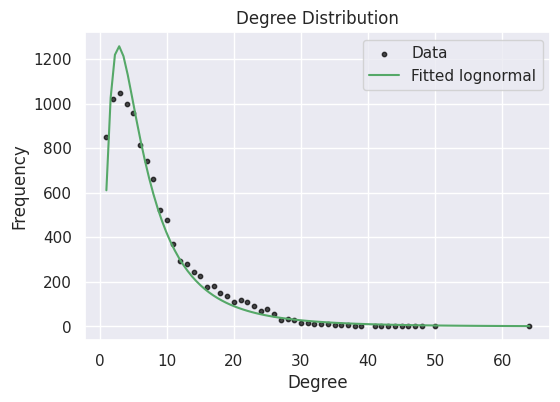

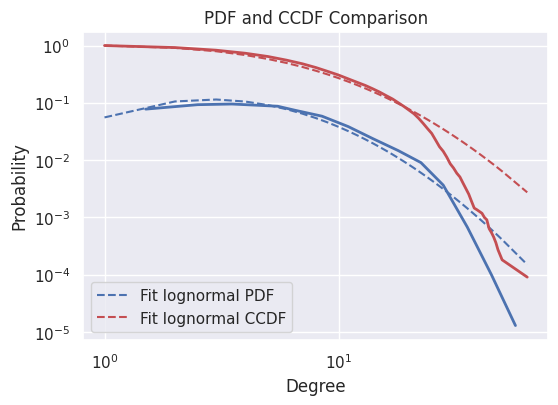


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : -75.863017599781
p          : 0.0
---------------------------------------------------
Alpha       : N/A
Xmin        : 1.0   
KS          : 0.06128268940050152
---------------------------------------------------



In [376]:
def get_degree_distr(G, distributions, xmin=None):
    degree_freq_list = [node.GetDeg() for node in G.Nodes()]
    
    DegToCntV = G.GetDegCnt()
    degree_freq_dict = {item.GetVal1(): item.GetVal2() for item in DegToCntV}
    degrees = np.array(list(degree_freq_dict.keys()))
    frequencies = np.array(list(degree_freq_dict.values()))

    fit = pl.Fit(degree_freq_list, discrete=True, linear_bins=True, xmin=xmin)  
    R, p = fit.distribution_compare(distributions[0], distributions[1], normalized_ratio=True)

    if R > 0:
        dist_name = distributions[0]
        selected_dist = getattr(fit, dist_name)
    else:
        dist_name = distributions[1]
        selected_dist = getattr(fit, dist_name)

    x_range = np.linspace(selected_dist.xmin, max(degree_freq_list), 100)
    y_range = [selected_dist.pdf(x) * len(degree_freq_list) for x in x_range]

    plt.figure(figsize=(6, 4))
    plt.scatter(degrees, frequencies, s=10, alpha=0.7, color='black', label="Data")
    plt.plot(x_range, y_range, color='g', linestyle='-', label=f"Fitted {dist_name}")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Degree Distribution")
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 4))
    fit.plot_pdf(color='b', linewidth=2, ax=ax)
    selected_dist.plot_pdf(ax=ax, color='b', linestyle='--', label=f"Fit {dist_name} PDF")
    fit.plot_ccdf(color='r', linewidth=2, ax=ax)
    selected_dist.plot_ccdf(ax=ax, color='r', linestyle='--', label=f"Fit {dist_name} CCDF")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.set_title("PDF and CCDF Comparison")
    plt.show()

    string = f"""
---------------------------------------------------
{dist_name.upper()} DISTRIBUTION FIT
R          : {R}
p          : {p}
---------------------------------------------------
Alpha       : {getattr(selected_dist, 'alpha', 'N/A')}
Xmin        : {selected_dist.xmin}   
KS          : {selected_dist.D}
---------------------------------------------------
"""
    return string

print(get_degree_distr(G, ['power_law', 'lognormal'], xmin=1))


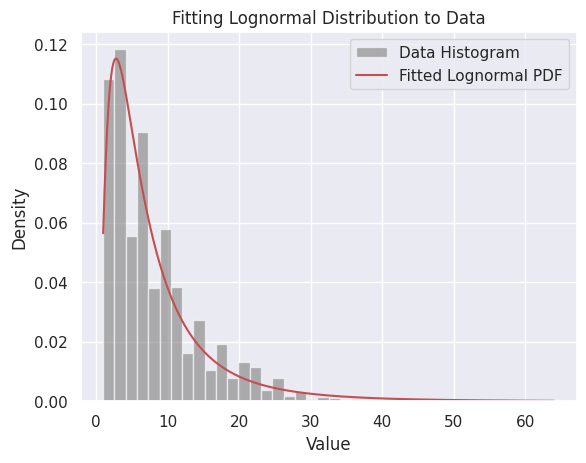

In [252]:
import scipy.stats as stats

def get_degree_distr(G):
    DegToCntV = G.GetDegCnt()
    degree_freq_dict = { item.GetVal1() : item.GetVal2() for item in DegToCntV }
    degree_freq_list = [ node.GetDeg() for node in G.Nodes() ]
    
    degrees = list(degree_freq_dict.keys())
    frequencies = list(degree_freq_dict.values())

    shape, loc, scale = stats.lognorm.fit(degree_freq_list, floc=0)
    x = np.linspace(min(degree_freq_list), max(degree_freq_list), 1000)
    pdf_fitted = stats.lognorm.pdf(x, shape, loc, scale)
    
    plt.hist(degree_freq_list, bins= 40, density=True, alpha=0.6, color='gray', label="Data Histogram")

    plt.plot(x, pdf_fitted, 'r-', label="Fitted Lognormal PDF")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    # plt.loglog()
    plt.title("Fitting Lognormal Distribution to Data")
    plt.show()

    return degree_freq_dict

DegToCntV = G.GetDegCnt()
degree_freq_dict = get_degree_distr(G)

# 3. Network Comparison

In [329]:
num_nodes = G.GetNodes()
num_edges = G.GetEdges()

random = snap.TRnd(42)

## [Preferential Attachment Network](ref:https://snap.stanford.edu/snappy/doc/reference/GenGeoPrefAttach.html?highlight=pref)

In [330]:
G_pref_attach = snap.GenGeoPrefAttach(num_nodes, num_edges, 0.25, random)

In [20]:
path = "../results/preferential_attachment_network.txt"
f = open(path, "a")

res_pref_attach = get_general_characteristics(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_degree_centrality(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_closeness_centrality(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

# res_pref_attach = get_farness_centrality(G_pref_attach)
# print(res_pref_attach)

res_pref_attach = get_eigenvector_centrality(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_path_length_diameter(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_innermos_k_shell(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_cluster_coeff(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)


   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 5039869
    Density             : 0.0021770407127645578
    Average Degree      : 0.08373696763877511
    Median Degree       : 0.08376629295415186
    Max Degree          : 0.09087594567496127
    Min Degree          : 0.07547169811320754
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 479823.83it/s]


   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 2417 has degree centrality of 0.09087594567496127. It has 0 contacts.
        
    Visitor (Node) 2876 has degree centrality of 0.0906936468872482. It has 0 contacts.
        
    Visitor (Node) 5697 has degree centrality of 0.0906936468872482. It has 0 contacts.
        
    Visitor (Node) 6076 has degree centrality of 0.0906936468872482. It has 0 contacts.
        
    Visitor (Node) 8612 has degree centrality of 0.0906936468872482. It has 0 contacts.
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [57:52<00:00,  3.16it/s] 


   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 5985 has closeness centrality of 0.3160942722138988. It has 0 contacts.
        
    Visitor (Node) 8848 has closeness centrality of 0.3159759223524668. It has 0 contacts.
        
    Visitor (Node) 1911 has closeness centrality of 0.31595772254701493. It has 0 contacts.
        
    Visitor (Node) 4924 has closeness centrality of 0.31593042676956745. It has 0 contacts.
        
    Visitor (Node) 4458 has closeness centrality of 0.31592132922509863. It has 0 contacts.
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 352510.58it/s]


    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 7424 has degree centrality of 0.014179313158475239. It has 0 contacts.
        
    Visitor (Node) 9822 has degree centrality of 0.014045851723108372. It has 0 contacts.
        
    Visitor (Node) 5985 has degree centrality of 0.014040599912983813. It has 0 contacts.
        
    Visitor (Node) 10346 has degree centrality of 0.014030007458113232. It has 0 contacts.
        
    Visitor (Node) 4086 has degree centrality of 0.014014974223625838. It has 0 contacts.
        
    ---------------------------------------------------
    


   
    ---------------------------------------------------
    Average Path Length : 3.190411957710536
    Diameter            : 6
    Effective Diameter  : (4.3898294215724, 4.3898294215724)
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Innermost k-shell : 829
    Number of nodes   : 10971
    Number of edges   : 5039041
    ---------------------------------------------------
    

    ---------------------------------------------------
    Clustering Coefficient : 0.5986646372754946
    ---------------------------------------------------
    


Calculating best minimal value for power law fit


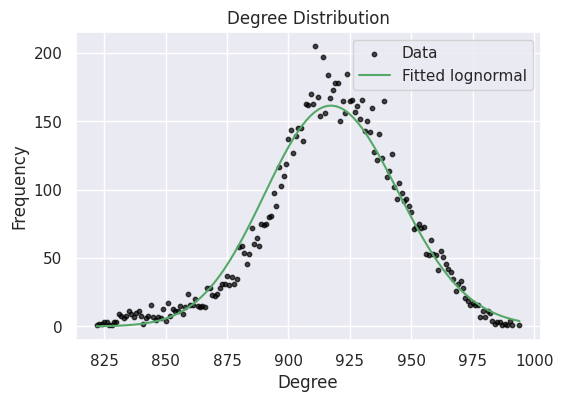

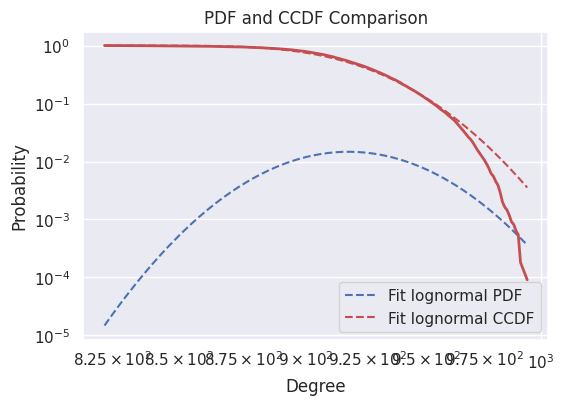


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : 99.66415850417447
p          : 0.0
---------------------------------------------------
Alpha       : N/A
Xmin        : 822.0   
KS          : 0.03824588205716173
---------------------------------------------------



In [383]:
print(get_degree_distr(G_pref_attach, ['lognormal', 'exponential'], xmin=None))

## [Configuration Model](ref:https://snap.stanford.edu/snappy/doc/reference/GenConfModel1.html?highlight=conf)

In [356]:
G_conf_model = snap.GenConfModel(G)

 configuration model: iter 43659: edges: 43639, left: 85677


In [26]:
path = "../results/configuration_model_network.txt"
f = open(path, "a")

res_conf_model = get_general_characteristics(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_degree_centrality(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_closeness_centrality(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

# res_conf_model = get_farness_centrality(G_conf_model)
# f.write(res_conf_model)
# print(res_conf_model)

res_conf_model = get_eigenvector_centrality(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_path_length_diameter(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_innermos_k_shell(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_cluster_coeff(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

f.close()

   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44476
    Density             : 0.2466948466588722
    Average Degree      : 0.0007389647176746384
    Median Degree       : 0.0005468963631391851
    Max Degree          : 0.005833561206817974
    Min Degree          : 9.114939385653085e-05
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 475874.34it/s]


   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 5568 has degree centrality of 0.005833561206817974. It has 0 contacts.
        
    Visitor (Node) 4113 has degree centrality of 0.004557469692826542. It has 0 contacts.
        
    Visitor (Node) 354 has degree centrality of 0.0041928721174004195. It has 0 contacts.
        
    Visitor (Node) 372 has degree centrality of 0.0041928721174004195. It has 0 contacts.
        
    Visitor (Node) 4334 has degree centrality of 0.0041928721174004195. It has 0 contacts.
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:52<00:00, 207.22it/s]


   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 5568 has closeness centrality of 0.2954382365699783. It has 0 contacts.
        
    Visitor (Node) 4113 has closeness centrality of 0.28281104062133633. It has 0 contacts.
        
    Visitor (Node) 10094 has closeness centrality of 0.2823662201206556. It has 0 contacts.
        
    Visitor (Node) 4257 has closeness centrality of 0.2819155390639564. It has 0 contacts.
        
    Visitor (Node) 3147 has closeness centrality of 0.2814084315800947. It has 0 contacts.
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 388206.20it/s]



    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 5568 has degree centrality of 0.09448341112449497. It has 0 contacts.
        
    Visitor (Node) 4113 has degree centrality of 0.05593778682944774. It has 0 contacts.
        
    Visitor (Node) 10094 has degree centrality of 0.05533348745751296. It has 0 contacts.
        
    Visitor (Node) 4257 has degree centrality of 0.0506541069044336. It has 0 contacts.
        
    Visitor (Node) 3147 has degree centrality of 0.05033261953581278. It has 0 contacts.
        
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Average Path Length : 4.377695675971538
    Diameter            : 7
    Effective Diameter  : (4.855971060574641, 4.855971060574641)
    ---------------------------------------------------
    
   
    --------------------------------------

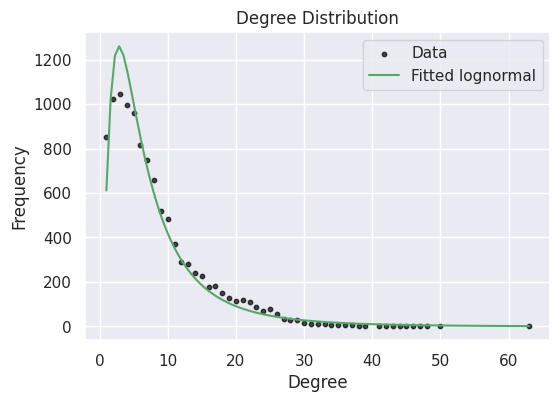

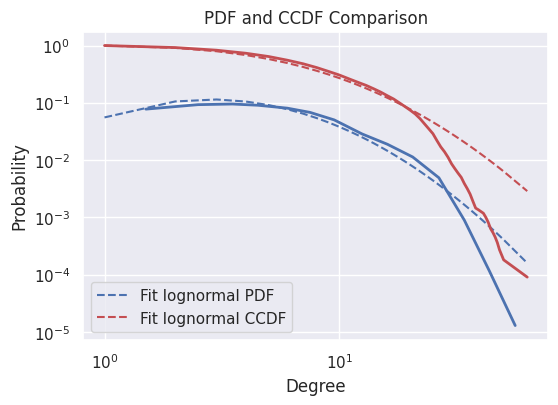


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : 75.88395848339111
p          : 0.0
---------------------------------------------------
Alpha       : N/A
Xmin        : 1.0   
KS          : 0.0614375303628274
---------------------------------------------------



In [379]:
print(get_degree_distr(G_conf_model, ['lognormal', 'power_law'], xmin=1))

## [Node Rewiring Model](ref:)

In [359]:
G_rewired = snap.GenRewire(G, 100, random)

Randomizing edges (10972, 44516)...
  total 8903k switchings attempted, 38k skiped  [7.72s]


In [28]:
path = "../results/rewired_network.txt"
f = open(path, "a")

res_rewired = get_general_characteristics(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_degree_centrality(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_closeness_centrality(G_rewired)
f.write(res_rewired)
print(res_rewired)

# res_rewired = get_farness_centrality(G_rewired)
# f.write(res_rewired)
# print(res_rewired)

res_rewired = get_eigenvector_centrality(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_path_length_diameter(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_innermos_k_shell(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_cluster_coeff(G_rewired)
f.write(res_rewired)
print(res_rewired)

f.close()

   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44516
    Density             : 0.24647317818312517
    Average Degree      : 0.0007396293140571141
    Median Degree       : 0.0005468963631391851
    Max Degree          : 0.005833561206817974
    Min Degree          : 9.114939385653085e-05
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 393631.94it/s]


   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has degree centrality of 0.005833561206817974. It has 570 contacts.
        
    Visitor (Node) 90636462 has degree centrality of 0.004557469692826542. It has 267 contacts.
        
    Visitor (Node) 94961689 has degree centrality of 0.004375170905113481. It has 129 contacts.
        
    Visitor (Node) 81068077 has degree centrality of 0.00428402151125695. It has 123 contacts.
        
    Visitor (Node) 80150715 has degree centrality of 0.0041928721174004195. It has 415 contacts.
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [01:11<00:00, 153.99it/s]


   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has closeness centrality of 0.29175276682258117. It has 570 contacts.
        
    Visitor (Node) 81068077 has closeness centrality of 0.2847592657491442. It has 123 contacts.
        
    Visitor (Node) 94961689 has closeness centrality of 0.28211594318533384. It has 129 contacts.
        
    Visitor (Node) 74317868 has closeness centrality of 0.2807333412519852. It has 108 contacts.
        
    Visitor (Node) 73334797 has closeness centrality of 0.28016543348903045. It has 319 contacts.
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 365446.16it/s]



    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has degree centrality of 0.08230432982031798. It has 570 contacts.
        
    Visitor (Node) 81068077 has degree centrality of 0.060054146400189745. It has 123 contacts.
        
    Visitor (Node) 94961689 has degree centrality of 0.054027327602562805. It has 129 contacts.
        
    Visitor (Node) 74317868 has degree centrality of 0.05092313182237545. It has 108 contacts.
        
    Visitor (Node) 90636462 has degree centrality of 0.04876793886564907. It has 267 contacts.
        
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Average Path Length : 4.244884548690335
    Diameter            : 8
    Effective Diameter  : (4.789579775469638, 4.789579775469638)
    ---------------------------------------------------
    
   
    ------

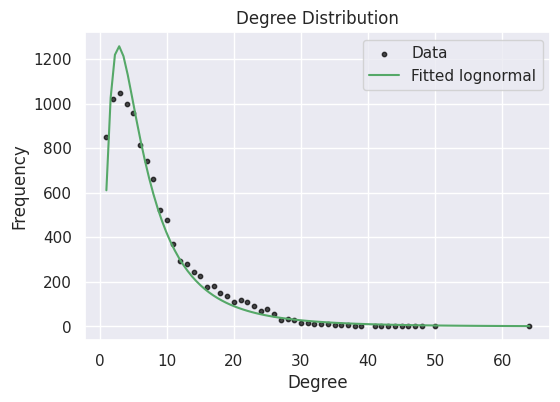

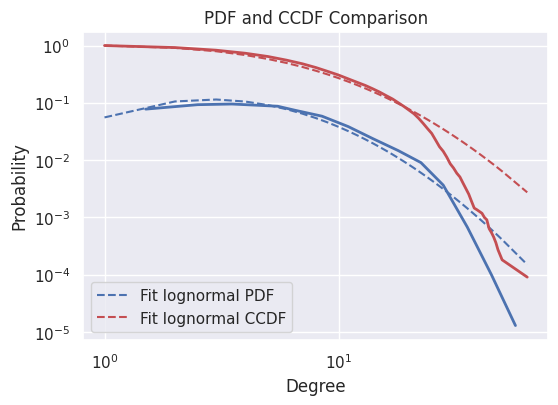


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : 75.863017599781
p          : 0.0
---------------------------------------------------
Alpha       : N/A
Xmin        : 1.0   
KS          : 0.06128268940050152
---------------------------------------------------



In [380]:
print(get_degree_distr(G_rewired, ['lognormal', 'power_law'], xmin=1))

## [Erdos-Reny random graph](href:https://snap.stanford.edu/snappy/doc/reference/GenRndGnm.html?highlight=erdos)

In [367]:
G_ER = snap.GenRewire(G, 100, random)

Randomizing edges (10972, 44516)...
  total 8903k switchings attempted, 38k skiped  [7.50s]


In [30]:

path = "../results/erdos_renyi_network.txt"
f = open(path, "a")

res_ER = get_general_characteristics(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_degree_centrality(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_closeness_centrality(G_ER)
f.write(res_ER)
print(res_ER)

# res_ER = get_farness_centrality(G_ER)
# f.write(res_ER)
# print(res_ER)

res_ER = get_eigenvector_centrality(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_path_length_diameter(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_innermos_k_shell(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_cluster_coeff(G_ER)
f.write(res_ER)
print(res_ER)

f.close()

   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44516
    Density             : 0.24647317818312517
    Average Degree      : 0.0007396293140571141
    Median Degree       : 0.0005468963631391851
    Max Degree          : 0.005833561206817974
    Min Degree          : 9.114939385653085e-05
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 352943.14it/s]


   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has degree centrality of 0.005833561206817974. It has 570 contacts.
        
    Visitor (Node) 90636462 has degree centrality of 0.004557469692826542. It has 267 contacts.
        
    Visitor (Node) 94961689 has degree centrality of 0.004375170905113481. It has 129 contacts.
        
    Visitor (Node) 81068077 has degree centrality of 0.00428402151125695. It has 123 contacts.
        
    Visitor (Node) 80150715 has degree centrality of 0.0041928721174004195. It has 415 contacts.
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [01:07<00:00, 163.50it/s]


   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has closeness centrality of 0.2883731036237123. It has 570 contacts.
        
    Visitor (Node) 76218374 has closeness centrality of 0.2840807466628947. It has 176 contacts.
        
    Visitor (Node) 81068077 has closeness centrality of 0.2823891796040936. It has 123 contacts.
        
    Visitor (Node) 90636462 has closeness centrality of 0.282301856248034. It has 267 contacts.
        
    Visitor (Node) 78184611 has closeness centrality of 0.28225094255948285. It has 290 contacts.
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 361371.23it/s]



    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has degree centrality of 0.073078504058018. It has 570 contacts.
        
    Visitor (Node) 81068077 has degree centrality of 0.05578462388733366. It has 123 contacts.
        
    Visitor (Node) 76218374 has degree centrality of 0.05543557573826591. It has 176 contacts.
        
    Visitor (Node) 90636462 has degree centrality of 0.05487729794201778. It has 267 contacts.
        
    Visitor (Node) 100270121 has degree centrality of 0.05209560780270704. It has 192 contacts.
        
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Average Path Length : 4.389666180226195
    Diameter            : 8
    Effective Diameter  : (4.971054186133935, 4.971054186133935)
    ---------------------------------------------------
    
   
    ---------

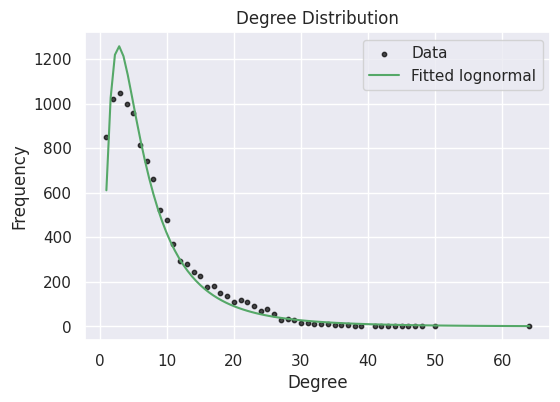

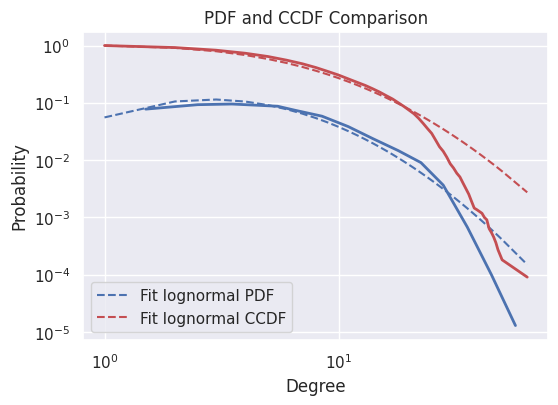


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : 75.863017599781
p          : 0.0
---------------------------------------------------
Alpha       : N/A
Xmin        : 1.0   
KS          : 0.06128268940050152
---------------------------------------------------



In [381]:
print(get_degree_distr(G_ER, ['lognormal', 'power_law'], xmin=1))

# Others

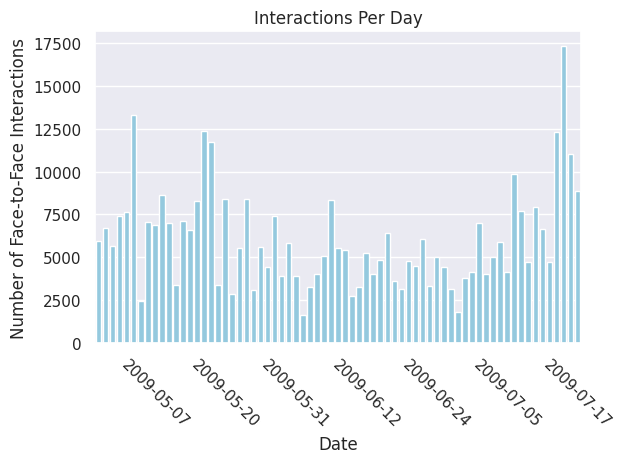

In [372]:
#Face-to-face contact distribution per day

df['date'] = df['contact_time'].dt.date

contact_counts = df.groupby('date').size()

sns.barplot(contact_counts, color='skyblue')

plt.xlabel('Date')
plt.ylabel('Number of Face-to-Face Interactions')
plt.title('Interactions Per Day')

plt.xticks(rotation=-45)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10)) 

plt.tight_layout() 
plt.show()
